In [1]:
# import modules
import numpy as np

# import plotting modules
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from IPython.display import Latex

%matplotlib inline

from matplotlib import gridspec
from NFW_Z import NFW_Z

## NOTE: The following code uses the ENCLOSED density within spherical shells.

In [2]:
class MakeMassProfile:

    
    def __init__(self, Mv):
        
        """Initiate the class with a known virial mass of the halo.
        Input: virial mass in kpc."""
        
        self.Mvir = Mv
    
    
    def find_mass_profile(self, raw_radius_data, radius_array, bin_size):
        
        """Derive a dark matter particle mass profile from raw data.
        Inputs:
        1) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        2) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        3) bin_size: integer that best matches the image resolution.
        Output: the dark matter particle mass profile."""
        
        mass_profile = np.zeros(np.size(radius_array))
        h = 0
        for radius_value in radius_array: # enclosed density
            particles_at_a_location = np.where((raw_radius_data < (radius_value + bin_size)))
            how_many_particles = np.size(particles_at_a_location)
            mass_profile[h] = how_many_particles * 500 #500 is 500 M_Sun, the mass per particle
            h += 1
        return mass_profile
    
    
    def get_new_Mvir(self, old_Mvir, redshift, new_Rvir):
        
        """This function is useful when the virial radius of SUBFIND data doesn't seem correct.
        The new virial radius is defined as the radius where density = ρ_{crit} x Δ_{vir} x Omega_{M}.
        Use the NFW_Z.py file (provided in the same folder as this) to generate a new virial mass
        based on this new virial radius.
        Inputs:
        1) old_Mvir: the total particle mass of the data, which is the mass enclosed by the biggest spherical shell.
        3) redshift: the redshift at which the data was taken.
        4) new_Rvir: the new virial radius, where density = ρ_{crit} x Δ_{vir} x Omega_{M}
        Output: the new virial mass, measured in solar masses."""
        
        halo = NFW_Z(old_Mvir, 'Jeon')
        new_Mvir = halo.M_vir(new_Rvir, redshift)
        return new_Mvir

    
    def final_plot(self, name, raw_radius_data, radius_array, quoted_Rvir, redshift, new_Rvir, bin_size, r_half):
        
        """This function produces the final plot, with the mass profile of the provided data and two pairs of
        similarly colored horizontal & vertical lines.
        Inputs:
        1) name: specs of dwarf (dwarf 1 or 2? z = ? RT or no RT?)
        2) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        3) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        4) quoted_Rvir: the virial radius quoted in the provided data. Unit: Kpc
        5) redshift: the redshift at which the data was taken.
        6) new_Rvir: the new virial radius, where density = ρ_{crit} x Δ_{vir} x Omega_{M}. Unit: kpc
        7) bin_size: integer that best matches the image resolution.
        8) M_half:
        9) r_half:
        Output: the final plot."""
        
        # extract the mass profile array from find_mass_profile
        massprof = self.find_mass_profile(raw_radius_data, radius_array, bin_size) 
        
        # extract the total particle mass of the data
        old_Mvir = self.find_mass_profile(raw_radius_data, radius_array, bin_size)[np.size(massprof) - 1]
        
        # extract the new virial mass calculated by get_new_Mvir
        new_Mvir = self.get_new_Mvir(old_Mvir, redshift, new_Rvir)
        
        # we all know what this is
        plt.figure(figsize=(10,10))

        # the main plot from data
        plt.plot(radius_array, massprof, color='#3185FC', linewidth=2)

        # horizontal & vertical lines representing M_vir and r_vir from data
        plt.axhline(old_Mvir, color='#4BC6B9', linewidth=2, linestyle='-.', label='M$_{tot}$ = ' + str(format(old_Mvir, '.2e')) + \
            ''' $M_\odot$,\ntotal particle mass from Jeon (2021)''') # enclosed
        plt.axvline(quoted_Rvir, color='#4BC6B9', linewidth=2, \
                    label='r$_{vir}$ = ' + str(round(quoted_Rvir, 2)) + ' kpc (Jeon, 2021)')

        # horizontal & vertical lines representing the newly found values of M_vir and r_vir
        plt.axvline(new_Rvir, color='#F26430', linewidth=2, label='new r$_{vir}$ = ' + \
                    str(round(new_Rvir, 2)) + ''' kpc''' + ',\nwhere ρ = $ρ_{crit}$ x $Δ_{vir}$ x $\Omega_{M}$')
        plt.axhline(new_Mvir, color='#F26430', linewidth=2, linestyle='-.', label='new M$_{vir}$ = ' + str(format(new_Mvir, '.2e')) + \
         '''$M_\odot$,\nderived from new r$_{vir}$''')
        
        # two more lines for M_half and r_half. for how these values are found, refer to the velocity codes.
        plt.axvline(r_half, color='hotpink', linewidth=2, label='r$_{half}$ = ' + str(r_half) + ' kpc')
        
        deviation_from_r_half = abs(radius_array - r_half)
        index = np.where(deviation_from_r_half == min(deviation_from_r_half))
        M_half = massprof[index][0]
        plt.axhline(M_half, color='hotpink', linewidth=2, linestyle='-.', label='M$_{half}$ = ' + \
                    str(format(M_half, '.2e')) + ' $M_\odot$')

        # the rest of the plot
        plt.legend(loc='lower center', prop={'size': 15})

        plt.xlabel('distance from dwarf center (kpc)', fontsize=17)
        plt.ylabel('dark matter particle mass profile (M$_\odot$)', fontsize=17) # using LATEX here!
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlim(10**-1.9, 10**1.4)
        plt.ylim(5e4, 5e8)
        plt.xscale('log')
        plt.yscale('log')    

#        plt.title('dark matter particle mass profile\nof ' + str(name), loc='center', fontsize=17)
        
        # lo and behold!
        plt.show()

# test #1: dwarf 1, RT

In [3]:
dm_290_RT = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf1/RT/dwarf_dm_5e8_rt_0290.txt")

dx_dm_290_RT = dm_290_RT[:,4] / 1000 # converting pc to kpc
dy_dm_290_RT = dm_290_RT[:,5] / 1000 # converting pc to kpc
dz_dm_290_RT = dm_290_RT[:,6] / 1000 # converting pc to kpc
r_dm_290_RT = np.sqrt(dx_dm_290_RT**2 + dy_dm_290_RT**2 + dz_dm_290_RT**2)

generated_array_1_RT = np.arange(0.01, 11.7, 0.02)

Jeon_Rvir_1_noRT = 1.1701e+04 * 0.001 # in kpc
Jeon_Mvir_1_noRT = 1.9122e+08 # in solar masses

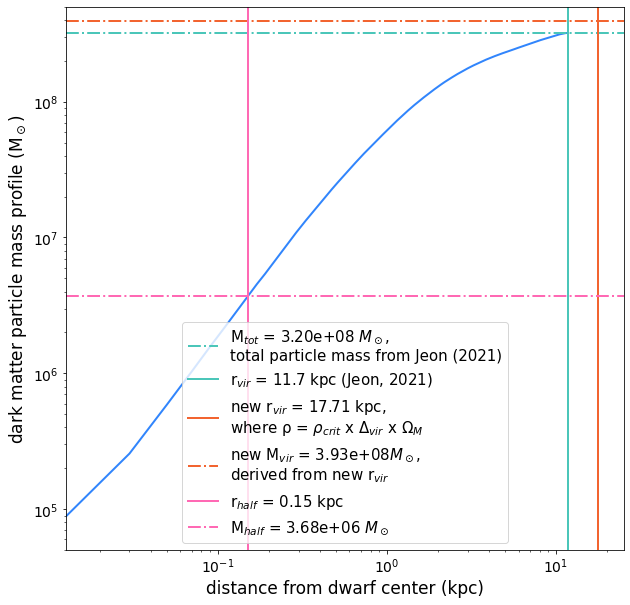

In [4]:
d1_RT = MakeMassProfile(Jeon_Mvir_1_noRT)

d1_RT.final_plot('dwarf 1, z = 0.130, with RT', r_dm_290_RT, generated_array_1_RT, \
                 Jeon_Rvir_1_noRT, 0.130, 17.71, 0.02, 0.15)

# test #2: dwarf 1, no RT

In [22]:
dm_290_noRT = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf1/noRT/dwarf_dm_5e8_0290.txt")

dx_dm_290_noRT = dm_290_noRT[:,4] / 1000 # converting pc to kpc
dy_dm_290_noRT = dm_290_noRT[:,5] / 1000 # converting pc to kpc
dz_dm_290_noRT = dm_290_noRT[:,6] / 1000 # converting pc to kpc
r_dm_290_noRT = np.sqrt(dx_dm_290_noRT**2 + dy_dm_290_noRT**2 + dz_dm_290_noRT**2)

generated_array_1_noRT = np.arange(0.01, 11.3, 0.02)

Jeon_Rvir_1_noRT = 1.1334e+04 * 0.001 # in kpc
Jeon_Mvir_1_noRT = 1.9030e+08 # in solar masses

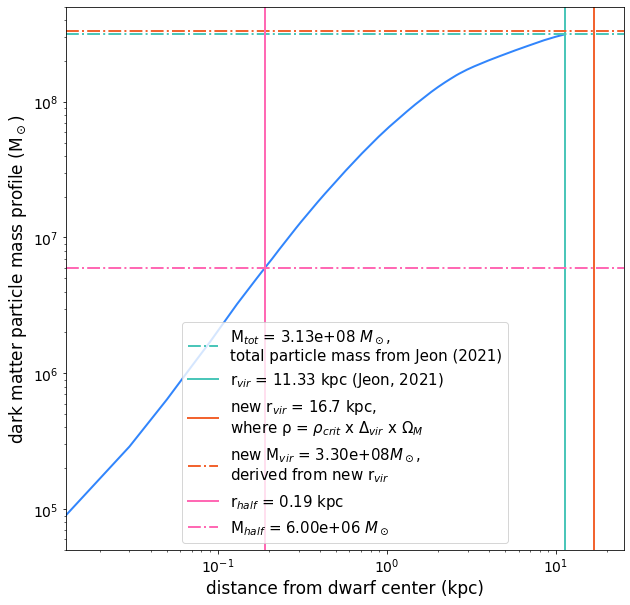

In [23]:
d1_noRT = MakeMassProfile(Jeon_Mvir_1_noRT)

d1_noRT.final_plot('dwarf 1, z = 0.130, without RT', r_dm_290_noRT, generated_array_1_noRT, \
                   Jeon_Rvir_1_noRT, 0.130, 16.7, 0.02, 0.19)

# test #3: dwarf 2, RT

In [17]:
dm_300_RT = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf2/RT/dwarf_dm_7e8_rt_0300.txt")

dx_dm_300_RT = dm_300_RT[:,4] / 1000 # converting pc to kpc
dy_dm_300_RT = dm_300_RT[:,5] / 1000 # converting pc to kpc
dz_dm_300_RT = dm_300_RT[:,6] / 1000 # converting pc to kpc
r_dm_300_RT = np.sqrt(dx_dm_300_RT**2 + dy_dm_300_RT**2 + dz_dm_300_RT**2)

generated_array_2_RT = np.arange(0.01, 9.73, 0.02)

Jeon_Rvir_2_RT = 9.7296e+03 * 0.001 # in kpc
Jeon_Mvir_2_RT = 1.0999e+08 # in solar masses

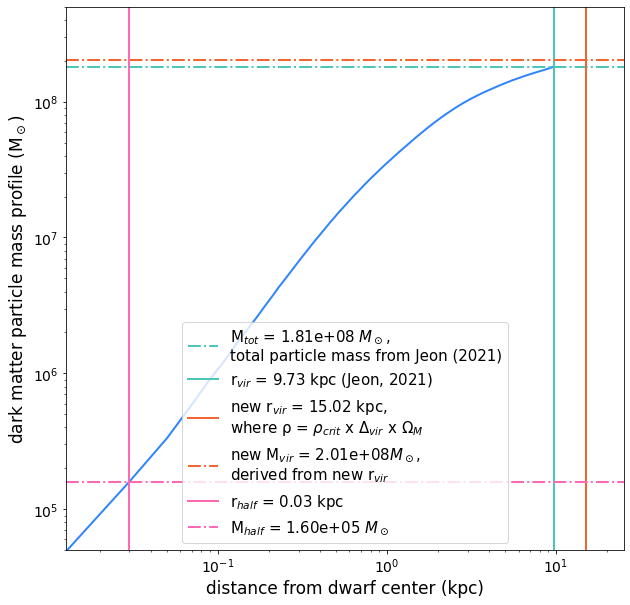

In [18]:
d2_RT = MakeMassProfile(Jeon_Mvir_2_RT)

d2_RT.final_plot('dwarf 2, z = 0.024, with RT', r_dm_300_RT, generated_array_2_RT, \
                   Jeon_Rvir_2_RT, 0.024, 15.02, 0.02, 0.03)

# test #4: dwarf 2, no RT

In [19]:
dm_300_noRT = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf2/noRT/dwarf_dm_7e8_0300.txt")

dx_dm_300_noRT = dm_300_noRT[:,4] / 1000 # converting pc to kpc
dy_dm_300_noRT = dm_300_noRT[:,5] / 1000 # converting pc to kpc
dz_dm_300_noRT = dm_300_noRT[:,6] / 1000 # converting pc to kpc
r_dm_300_noRT = np.sqrt(dx_dm_300_noRT**2 + dy_dm_300_noRT**2 + dz_dm_300_noRT**2)

generated_array_2_noRT = np.arange(0.01, 9.75, 0.02)

Jeon_Rvir_2_noRT = 9.7521e+03 * 0.001 # in kpc
Jeon_Mvir_2_noRT = 1.1077e+08 # in solar masses

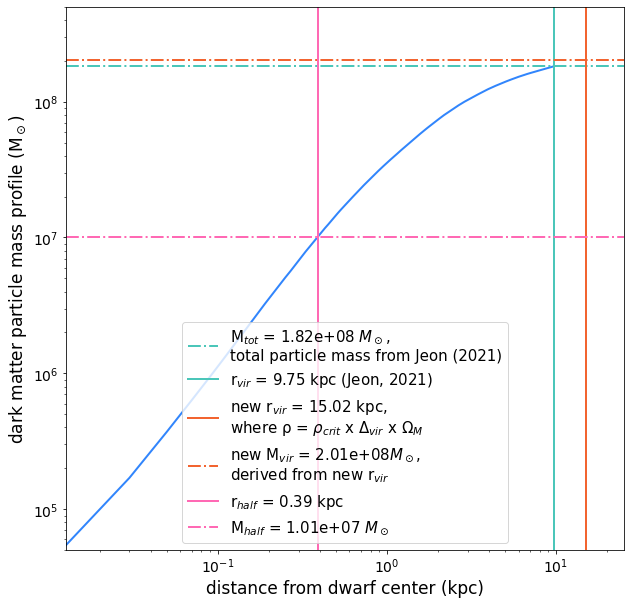

In [20]:
d2_noRT = MakeMassProfile(Jeon_Mvir_2_noRT)

d2_noRT.final_plot('dwarf 2, z = 0.024, without RT', r_dm_300_noRT, generated_array_2_noRT, \
                   Jeon_Rvir_2_noRT, 0.024, 15.02, 0.02, 0.39)